## Feature Engineering for the Kaggle competition :  [Customer Transaction Prediction](https://www.kaggle.com/c/santander-customer-transaction-prediction/overview) of SANTANDER
---
### Competition introduction
*At Santander our mission is to help people and businesses prosper. We are always looking for ways to help our customers understand their financial health and identify which products and services might help them achieve their monetary goals.*

*Our data science team is continually challenging our machine learning algorithms, working with the global data science community to make sure we can more accurately identify new ways to solve our most common challenge, binary classification problems such as: is a customer satisfied? Will a customer buy this product? Can a customer pay this loan?*

*In this challenge, we invite Kagglers to help us identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem.*


### Data
- We are provided with an anonymized dataset containing numeric feature variables, the binary target column, and a string `ID_code` column.

- The task is to predict the value of target column in the test set.

- File descriptions

    `train.csv` - the training set.
    
    `test.csv` - the test set. The test set contains some rows which are not included in scoring.
    
    `sample_submission.csv` - a sample submission file in the correct format.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
import lightgbm
%matplotlib inline

In [2]:
def plot_formatting():
    '''
    Set up the default plotting settings.
    '''
    
    plt.rc(
        'figure',
        figsize=(12,6),
        titleweight='bold',
        titlesize=25
    )
    plt.rc(
        'axes',
        labelweight='ultralight',
        titleweight='ultralight',
        titlelocation='left',
        titlecolor='k',
        titley=1.03,
        titlesize=16,
        grid=True
    )
    plt.rc(
        'axes.spines',
        right=False,
        left=False,
        top=False   
    )
    plt.rc(
        'grid',
        color='k',
        linestyle=(0,15,2,0),
        alpha=0.5
    )
    plt.rc('axes.grid', axis='y')
    plt.rc('ytick.major', width=0)
    plt.rc('font', family='monospace')
    
plot_formatting() # Setting our default settings

In [4]:
train = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/train.csv')
test = pd.read_csv('../input/test-ctr/real_test.csv')

In [5]:
test_index = test['ID_code']

# Separate features from the label
y = train['target']
train = train.loc[:, 'var_0':'var_199']

## Visualizing data with PCA

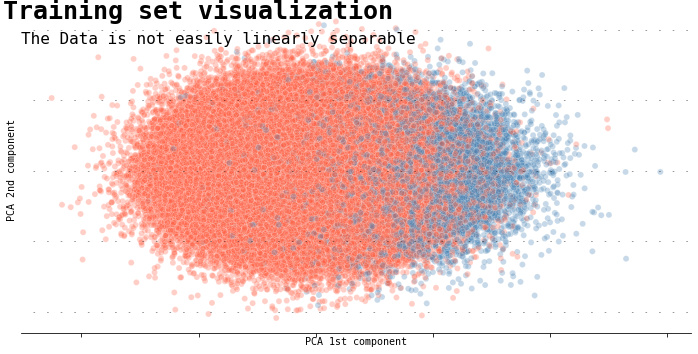

In [12]:
# Standardizing the data for PCA
X_stand = StandardScaler().fit_transform(train)

# Two components to visualize
pca = PCA(n_components=2).fit(X_stand)
X_pca = pca.transform(X_stand)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], c=y.map({0: 'tomato', 1: 'steelblue'}), alpha=0.3)
plt.suptitle('Training set visualization', x=0.33, y=0.9)
plt.title('The Data is not easily linearly separable', y=0.87)
plt.tick_params(labelbottom=False, labelleft=False)
plt.xlabel('PCA 1st component')
plt.ylabel('PCA 2nd component');

## Baseline score

In [13]:
def score_dataset(X, y, model = XGBClassifier(objective = 'binary:logistic', tree_method='gpu_hist',
                                              eval_metric = 'auc', use_label_encoder=False, random_state=0)):
    '''
    Used to score the dataset each time new features are added to it.
    To assess the relevance of new features.
    '''
    
    score = cross_val_score(
        model, X.values, y.values, cv=5, scoring="roc_auc"
    )
    print('CV scores: ', score)
    print('Mean score: ', score.mean())
    return 

In [24]:
def score_lightgbm(X, y):
    
    '''
    Used to score the dataset each time new features are added to it.
    To assess the relevance of new features.
    '''
    
    folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=14)
    oof = np.zeros(len(X))
    
    param = {
    'boost': 'gbdt',
    'metric':'auc'
}

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X.values, y.values)):
        
        trn_data = lightgbm.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
        val_data = lightgbm.Dataset(X.iloc[val_idx], label=y.iloc[val_idx])

        clf = lightgbm.train(param, train_set=trn_data, num_boost_round=2500,
                             valid_sets = [trn_data, val_data],
                             early_stopping_rounds = 300, verbose_eval=False);
        
        oof[val_idx] = clf.predict(X.iloc[val_idx], num_iteration=clf.best_iteration)

    print("CV score: {:<8.5f}".format(roc_auc_score(y, oof)))
    return

In [ ]:
# score_dataset(train, y)

In [25]:
score_lightgbm(train, y)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.252657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 200
[LightGBM] [Info] Start training from score 0.100493
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.388324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 200
[LightGBM] [Info] Start training from score 0.100485
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.270118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 133334, number of used features: 200
[LightGBM

## Mutual Information scores of features with the target

In [26]:
mi_scores = mutual_info_classif(train, y, random_state=0)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=train.columns)

## Drop uninformative features

In [27]:
def drop_uninformative(df):
    '''
    Keeps features with non-zero MI scores.
    '''
    return df.loc[:, mi_scores > 0] 

In [28]:
X = train.copy()
X = drop_uninformative(X)

score_lightgbm(X, y)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 37995
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 149
[LightGBM] [Info] Start training from score 0.100493
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.199523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37995
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 149
[LightGBM] [Info] Start training from score 0.100485
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37995
[LightGBM] [Info] Number of data points 

The score drops. It is preferable to keep those features even though they have zero MI scores.

In [29]:
print('Percentage of duplicates Train:')
train.loc[:, 'var_0':'var_199'].apply(lambda x: 1 - len(x.unique()) / len(train), axis=0)

Percentage of duplicates Train:


var_0      0.526640
var_1      0.455340
var_2      0.567225
var_3      0.627015
var_4      0.682425
             ...   
var_195    0.710650
var_196    0.372200
var_197    0.797315
var_198    0.529235
var_199    0.252850
Length: 200, dtype: float64

In [30]:
print('Percentage of duplicates Test:')
test.loc[:, 'var_0':'var_199'].apply(lambda x: 1 - len(x.unique()) / len(train), axis=0)

Percentage of duplicates Test:


var_0      0.672100
var_1      0.641695
var_2      0.690675
var_3      0.717465
var_4      0.750025
             ...   
var_195    0.767590
var_196    0.609810
var_197    0.825915
var_198    0.673690
var_199    0.570335
Length: 200, dtype: float64

## Count features

In [31]:
def count_features(df):
    return df.apply(lambda x: x.groupby(x).transform('count'), axis=0)

In [32]:
df = pd.concat([train, test.loc[:, 'var_0':'var_199']], axis=0).reset_index().drop('index', axis=1)
X = df.copy()
new_columns = count_features(X)
X = X.join(new_columns.add_prefix('Count_'))
X = X.iloc[:len(train)]
score_lightgbm(X, y)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.560129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55186
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 400
[LightGBM] [Info] Start training from score 0.100493
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.567531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55184
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 400
[LightGBM] [Info] Start training from score 0.100485
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.550495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55184
[LightGBM] [Info] Number of data points in the train set: 133334, number of used features: 400
[LightGBM

It is a good increase. There might be an interaction between raw and count features though. If so, it will probably increase even more our score. To see this, let's combine them. The following "unique_columns" function will create two new columns for each feature:
- The first column will only keep unique entries and impute Nan to non unique entries.
- The second column will keep non-unique entries and impute Nan to unique entries.

In [33]:
def unique_columns(df):
    '''
    Returns a transformed version of the dataframe.
    Where each raw feature is replace by two new corresponding columns:
        - One column will impute NaN to unique entries and keep non-unique ones.
        - The other one will not impute NaN only to unique entries.
    '''
    
    #Calculate counts to see the frequency of each entry
    unique_df = df.apply(lambda x: x.groupby(x).transform('count'), axis=0)
    
    #Impute NaNs 
    unique_columns = df.where(unique_df == 1)
    non_unique = df.where(unique_df > 1)
    
    return non_unique.add_prefix('NU_').join(unique_columns.add_prefix('U_'))

In [34]:
X = df.copy()
X = unique_columns(X)
X = X.iloc[:len(train)]
score_lightgbm(X, y)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.511376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100217
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 400
[LightGBM] [Info] Start training from score 0.100493
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.509793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100184
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 399
[LightGBM] [Info] Start training from score 0.100485
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.929717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100186
[LightGBM] [Info] Number of data points in the train set: 133334, number of used features: 399
[Light

## Gaussian Naive Bayes Predict_proba

The EDA showed that data points are samples from a mutlivariate gaussian distribution. It also showed that the features are independent. Therefore, all critical assumptions of a Gaussian Naive Bayes model are reunited here. We could use a little part of our dataset to train a Gaussian NB model and give new features (being the predic_proba of this model) to the remaining data.

In [35]:
# def GNB_features(X_train, X, y_train, test_df=None):
#     X = X.copy()
#     if test_df:
#         test_df = test_df.copy()
#     for i, feature in enumerate(X_train.columns):
#         clf = GaussianNB().fit(X_train[[feature]], y_train)
#         X['GNB_' + str(i)] =  clf.predict(X[[feature]])
#         if test_df:
#             test_df['GNB_' + str(i)] =  clf.predict(test_df[[feature]])
    
#     return X, test_df
    

## First principal component:

In [36]:
def PCA_feature(df):
    
    Stand_df = StandardScaler().fit_transform(df)
    pca = PCA(n_components=1).fit(Stand_df)
    X_pca = pca.transform(Stand_df)
    
    return X_pca, pca

In [38]:
X = train.copy()

X['PC1'] = PCA_feature(X)[0]
score_lightgbm(X, y)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51255
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 201
[LightGBM] [Info] Start training from score 0.100493
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.268510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51255
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 201
[LightGBM] [Info] Start training from score 0.100485
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.269492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51255
[LightGBM] [Info] Number of data points in the train set: 133334, number of used features: 201
[LightGBM

## Add clustering features
We could either add the cluster labels as a column or distances of each data point from cluster centroids.

After tuning, the optimal number of clusters is 3.


In [1]:
def cluster_labels(df, features, n_clusters=3):
    # After tuning, the optimal number of clusters chosen 3
    
    X = df.copy()
    X = X.loc[:, features]
    X_scaled = StandardScaler().fit_transform(X)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0) 
    
    return kmeans.fit_predict(X_scaled)


def centroid_distance(df, features, n_clusters=3):
    # After tuning, the optimal number of clusters chosen 3
    
    X = df.copy()
    X = X.loc[:, features]
    X_scaled = StandardScaler().fit_transform(X)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=0).fit(X_scaled)
    
    X_cd = kmeans.transform(X_scaled)
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return kmeans, X_cd

In [40]:
X = train.copy()
X['Cluster'] = cluster_labels(X, X.columns)
score_lightgbm(X, y)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.264736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51020
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 201
[LightGBM] [Info] Start training from score 0.100493
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.275120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51020
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 201
[LightGBM] [Info] Start training from score 0.100485
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.270381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51020
[LightGBM] [Info] Number of data points in the train set: 133334, number of used features: 201
[LightGBM

In [41]:
X = train.copy()
kmeans, dist = centroid_distance(X, X.columns)
X = X.join(dist)
score_lightgbm(X, y)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.274014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51765
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 203
[LightGBM] [Info] Start training from score 0.100493
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51765
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 203
[LightGBM] [Info] Start training from score 0.100485
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.279235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51765
[LightGBM] [Info] Number of data points in the train set: 133334, number of used features: 203
[LightGBM

## Dataset transformation

In [42]:
df = pd.concat([train, test.loc[:, 'var_0':'var_199']], axis=0).reset_index().drop('index', axis=1)

In [43]:
X = df.copy()

_, dist = centroid_distance(X, X.columns)
new_columns = unique_columns(X)
X_pca, _ = PCA_feature(X)

X = new_columns.join(dist)
X['PC1'] = X_pca

train = X.iloc[:len(train)]
test = X.iloc[len(train):len(train) + len(test)]

In [44]:
len(train.columns)

404

In [45]:
score_lightgbm(train, y)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.875718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 101237
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 404
[LightGBM] [Info] Start training from score 0.100493
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.613789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 101204
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 403
[LightGBM] [Info] Start training from score 0.100485
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.601774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 101206
[LightGBM] [Info] Number of data points in the train set: 133334, number of used features: 403
[Light

In [ ]:
# score_dataset(train, y)

In [ ]:
train['target'] = y.copy()
test = test.reset_index().drop('index', axis=1)
test['ID_code'] = test_index

In [ ]:
train.to_csv('final_train.csv', index=False)
test.to_csv('final_test.csv', index=False)